In [50]:
import copy
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import keras
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import roc_curve
import tensorflow as tf
import os

# Loading data

In [4]:
# Parameters
fs = 44100                  # Hz, sampling frequency
f_size = 512                # Frame size
h_size = int(f_size/2)      # Hop size
supra_frame_duration = 0.5  # seconds
frame_num_gl = round(supra_frame_duration / (h_size/fs))
n_mel = 64
dir_HC = 'wav'+ os.sep + 'HC' + os.sep
dir_ALS = 'wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

In [ ]:
X = np.zeros((20000,n_mel,frame_num_gl))    # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])                            # IDs of the speakers
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):
    if directory_HC[i][-9:]=='a_mel.dat':
        fileName = dir_HC + directory_HC[i]
        
        # print(fileName)

        X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
        X_spec = np.reshape(X_spec,(n_mel, np.floor(len(X_spec)/n_mel).astype(int)))
        
        # plt.subplots(dpi=150)
        # plt.pcolor(X_spec,shading='flat',cmap='jet')
        # plt.xlabel('Номер фрейма')
        # plt.ylabel('$\log(|X(k,m)|)$')
        # plt.show()

#       #Запись фрагметов спектра в трехмерный массив 
        frame_num = X_spec.shape[1]
        N_supra_frames = frame_num - frame_num_gl + 1

        # generator comprehension
        gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
        for n in gen_range:
            X[X_global_index,:,:] = X_spec[:,n:n+frame_num_gl]
            X_ids.append(int(directory_HC[i][0:3]))
            y[X_global_index] = 0
            X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-9:]=='a_mel.dat':
        fileName = dir_ALS + directory_ALS[i]        

        # print(fileName)

        X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
        X_spec = np.reshape(X_spec,(n_mel, np.floor(len(X_spec)/n_mel).astype(int)))

#       #Запись фрагметов спектра в трехмерный массив
        frame_num = X_spec.shape[1]
        N_supra_frames = frame_num - frame_num_gl + 1

        # generator comprehension
        gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
        for n in gen_range:
            X[X_global_index,:,:] = X_spec[:,n:n+frame_num_gl]
            X_ids.append(int(directory_ALS[i][0:3]))
            y[X_global_index] = 1
            X_global_index = X_global_index + 1
            
inds_to_delete = np.array(range(y.shape[0]))>=X_global_index
y = np.delete(y,inds_to_delete)
X = np.delete(X,inds_to_delete, axis=0)

# Data normalization

In [15]:
X_mean = tf.reduce_mean(X, axis = 0).numpy()
X_zero_mean = X - X_mean
X_sd   = np.sqrt(tf.reduce_mean((X_zero_mean)**2, axis = 0).numpy())
# X_sd = np.sqrt(X_sd.reshape(X.shape[0],1))

print('mean(X[2,:]) = ', X_mean[0])
print('SD(X[2,:]) = ', X_sd[0])

# X_normalized = keras.layers.UnitNormalization(axis=1)(X)
# X_normalized = X_normalized.numpy()

X_normalized = (X_zero_mean)/X_sd

# print('mean(X_normalized[2,:]) = ', np.mean(X_normalized[:,:,2]))
# print('SD(X_normalized[2,:]) = ', np.std(X_normalized[:,:,0]))

mean(X[2,:]) =  [-35.8262778  -35.85557905 -35.83792167 -35.86602345 -35.84714869
 -35.8790972  -35.85516558 -35.8916828  -35.86320764 -35.90192537
 -35.86851028 -35.90863185 -35.88083687 -35.91569122 -35.89347623
 -35.92152638 -35.90267594 -35.93181931 -35.91274527 -35.94708844
 -35.92294048 -35.95809907 -35.93561269 -35.96967722 -35.94698005
 -35.98083891 -35.9602471  -35.98950397 -35.97157307 -36.00059056
 -35.98394019 -36.01328539 -35.9942425  -36.02360818 -36.00514561
 -36.03583108 -36.01169635 -36.04410698 -36.02135732 -36.05080195
 -36.0323957  -36.05788905 -36.04422134 -36.06721848 -36.051963
 -36.07886192 -36.06115845 -36.08985548 -36.07033085 -36.0994627
 -36.08115032 -36.10709513 -36.09474422 -36.11916868 -36.1038364
 -36.13082279 -36.11679621 -36.1440574  -36.12505718 -36.15511838
 -36.13410328 -36.16420545 -36.14582352 -36.17370811 -36.15488327
 -36.18253617 -36.16601082 -36.19223469 -36.17565644 -36.20557129
 -36.18437654 -36.21622349 -36.1928389  -36.22834142 -36.2022075

# Train/Test sets

In [16]:
test_subjects_ids = (25, 26, 32, 61, 62, 107) # 3 -> ALS;  3-> HC

test_inds_in_dataset = (i for i in range(len(X_ids)) if X_ids[i] in test_subjects_ids)
test_inds_in_dataset = list(test_inds_in_dataset)

train_inds_in_dataset = (i for i in range(len(X_ids)) if (X_ids[i] not in test_subjects_ids))
train_inds_in_dataset = list(train_inds_in_dataset)

X_test  = X_normalized[test_inds_in_dataset,:,:]
y_test  = y[test_inds_in_dataset]

X_train = X_normalized[train_inds_in_dataset,:,:]
y_train = y[train_inds_in_dataset]

In [2]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

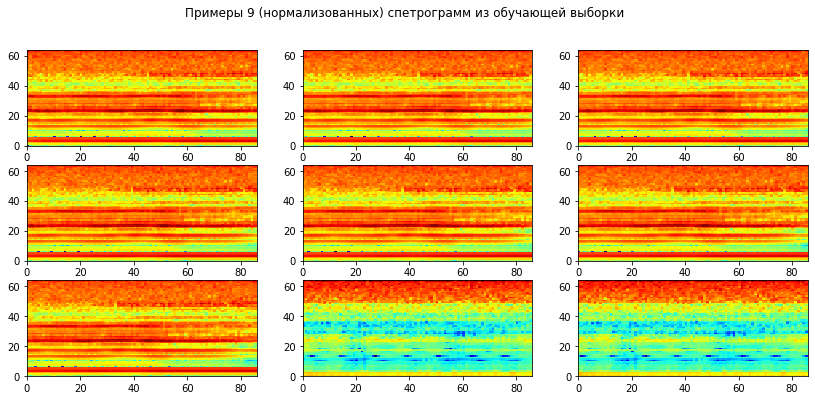

In [17]:
# отображение первых 25 изображений из обучающей выборки
f, a = plt.subplots(3, 3, figsize=(14,6))
f.suptitle('Примеры 9 (нормализованных) спетрограмм из обучающей выборки')
for i in range(9):
    plt.subplot(3,3,i+1)
    # plt.xticks([])
    # plt.yticks([])
    # plt.imshow(X_train[i], cmap='jet')
    plt.pcolor(X_train[i+200], cmap='jet')

plt.show()

In [56]:
# for tanh activation
# y_test[y_test==-1] = 0
# y_train[y_train==-1] = 0

In [61]:
model = keras.Sequential([
    Flatten(input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.5),
    Dense(1, 
        activation='sigmoid',
        kernel_regularizer=keras.regularizers.L1(0.2),
        kernel_initializer=keras.initializers.GlorotNormal(seed=1))
])

print(model.summary())      # вывод структуры НС в консоль

lr_schedule = keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)
my_optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.8)

model.compile(optimizer=my_optimizer,
            #  optimizer='adam', # bad choice
             # loss='mean_squared_error',
             loss=keras.losses.BinaryCrossentropy(from_logits=False),
             metrics=['accuracy', keras.metrics.Precision(), 
             keras.metrics.Recall()])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 5504)              0         
                                                                 
 dropout_4 (Dropout)         (None, 5504)              0         
                                                                 
 dense_13 (Dense)            (None, 1)                 5505      
                                                                 
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________
None


## Train process

In [60]:
# X_tr = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))

epochs_num = 40

hist = model.fit(X_train, y_train, batch_size=200, epochs=epochs_num, validation_split=0.3)

Epoch 1/40


InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_6356\333640369.py", line 5, in <cell line: 5>
      hist = model.fit(X_train, y_train, batch_size=200, epochs=epochs_num, validation_split=0.3)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\metrics\metrics.py", line 818, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.debugging.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential_12/dense_12/Tanh:0) = ] [[0.998435438][-0.747833967][0.829633534]...] [y (Cast_6/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]] [Op:__inference_train_function_186008]

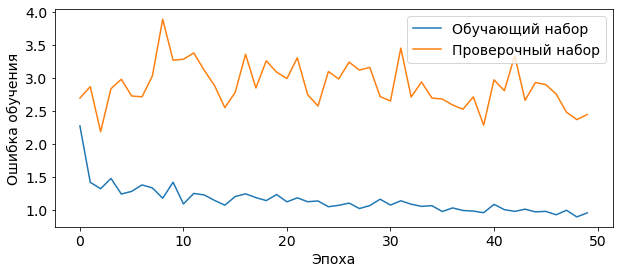

In [49]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

fig, ax = plt.subplots(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
plt.plot(range(epochs_num), train_loss, label='Обучающий набор')
plt.plot(range(epochs_num), val_loss, label='Проверочный набор')
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('Ошибка обучения')


#Saving results
image_name = f'figures/loss_NN.jpg'
# fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

# Prediction

In [39]:
# model.evaluate(X_test, y_test)

y_est = model.predict(X_test)   # training = False
y_est = np.reshape(y_est,(y_est.shape[0]))
# y_est = 1-y_est

78/78 [==============================] - 0s 2ms/step


AUC = 0.994
Prec = 0.952
Recall = 0.992


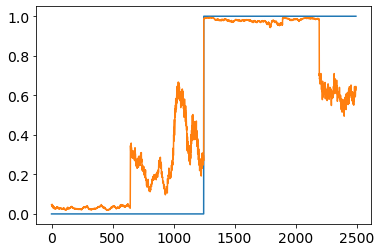

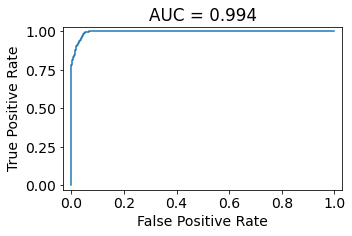

In [40]:
def plot_roc_curve(fpr,tpr,auc): 
  fig,ax = plt.subplots(figsize=(5,3))
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.title(f'AUC = {auc:2.3f}')
  plt.xlim((-0.03, 1.03))
  plt.ylim((-0.03, 1.03))
  return fig

# y_est = np.squeeze(y_est,axis=2)

auc_func = keras.metrics.AUC(thresholds=np.linspace(0,1.0,20))
auc_func.update_state(y_test, y_est)
AUC = auc_func.result().numpy()

fpr, tpr, thresholds = roc_curve (y_test, y_est, pos_label=1.0)    

effectiveness = tpr -fpr
idx = np.argmax(effectiveness)
best_thrs  = thresholds[idx]


prec_func = keras.metrics.Precision(thresholds=best_thrs)
prec_func.update_state(y_test, y_est)
Prec = prec_func.result().numpy()

recall_func = keras.metrics.Recall(thresholds=best_thrs)
recall_func.update_state(y_test, y_est)
Recall = recall_func.result().numpy()

print(f'AUC = {AUC:2.3f}')
print(f'Prec = {Prec:2.3f}')
print(f'Recall = {Recall:2.3f}')

plt.plot(y_test)
plt.plot(y_est)

fig = plot_roc_curve (fpr, tpr, AUC)

plt.show()
# Saving results
# image_name = 'figures/AUC_keras_NN_2_Layers_40_hidden_units_dropout_5_mfcc_frames.jpg'
# fig.savefig(image_name, format='jpg', dpi=140, bbox_inches='tight', pad_inches = 0.2)